In [100]:
import numpy as np
import matplotlib.pyplot as plt

### Gaussian Process Regression

In [143]:
class gaussian_process_regression(object):
    def __init__(self):
        self.l = 0.5
        self.var_k = 1.0
        self.var_l = .2**2
    
    def preprocess(self,x,y=None):
        if len(x.shape) == 1:
            x = x.reshape(-1,1)
        if y is not None:
            y = y.reshape(-1,1)
        return x,y
    
    def rbf_kernel(self,a,b):
        z = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2.0 * a.dot(b.T)
        return self.var_k * np.exp(-.5 * (1.0/self.l**2) * z)
        
    def train(self,x,y):
        x,y = self.preprocess(x,y)
        
        K = self.rbf_kernel(x,x)
        K += np.eye(x.shape[0])*self.var_l
        K = np.linalg.inv(K)
        self.K = K
        self.x_train = x
        self.y_train = y
        
    def predict(self,x):
        x,_ = self.preprocess(x)
        
        K_s = self.rbf_kernel(x,self.x_train)
        mean = K_s.dot(self.K).dot(self.y_train)
        K_ss = self.rbf_kernel(x,x)
        covariance = K_ss - K_s.dot(self.K).dot(K_s.T)
        variance = np.diag(covariance)
        
        return mean, variance

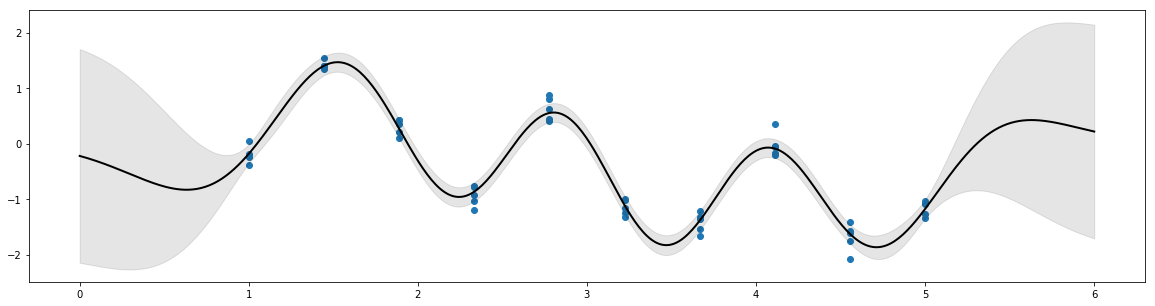

In [151]:
N = 10
sigma = .2
X_train = np.linspace(1,5,N).reshape(-1,1)
X_train = np.concatenate(5*[X_train])
Y_train = np.sin(5*X_train) + np.cos(.7*X_train) + np.random.normal(0,sigma,X_train.shape[0]).reshape(-1,1)
n = 500
X_test = np.linspace(0,6,n).reshape(-1,1)

model = gaussian_process_regression()
model.train(X_train,Y_train)
mu_predictions, var_predictions = model.predict(X_test)
var_predictions = var_predictions.reshape(-1,1)

plt.figure(figsize=(20,5))
plt.plot(X_test, mu_predictions, 'k', mew=1, lw=2, label='Mean Prediction')
plt.scatter(X_train, Y_train)
plt.fill_between(X_test[:,0], 
                 mu_predictions[:,0] - 1.96*np.sqrt(var_predictions[:,0]), 
                 mu_predictions[:,0] + 1.96*np.sqrt(var_predictions[:,0]),
                 color='k', alpha=.1, label='95% Credible Interval' )
plt.show()

### Gaussian Process Classification (Binomial)

In [270]:
class gaussian_process_classification_binomial(object):
    def __init__(self):
        self.l = 1.0
        self.var_k = 1.0
        self.var_l = 0.2**2
        
    def preprocess(self,x,y=None):
        if len(x.shape) == 1:
            x = x.reshape(-1,1)
        if y is not None:
            y = y.reshape(-1,1)
        return x,y
            
    def rbf_kernel(self,a,b):
        z = np.sum(a**2,1).reshape(-1,1)  + np.sum(b**2,1) -2.0*a.dot(b.T)
        return self.var_k * np.exp(-0.5*(1.0/self.l**2)*z)
        
    def train(self,x,y):
        x,y = self.preprocess(x,y)
        
        K = self.rbf_kernel(x,x) + np.eye(x.shape[0])*self.var_l
        K = np.linalg.inv(K) 
        self.K = K
        self.x_train = x
        self.y_train = y
        
    def predict(self,x):
        x,_ = self.preprocess(x)
        
        K_s = self.rbf_kernel(x,self.x_train)
        mean = K_s.dot(self.K).dot(self.y_train)
        K_ss = self.rbf_kernel(x,x)
        covariance = K_ss - K_s.dot(self.K).dot(K_s.T)
        variance = np.diag(covariance)
        
        return mean, variance
        
        

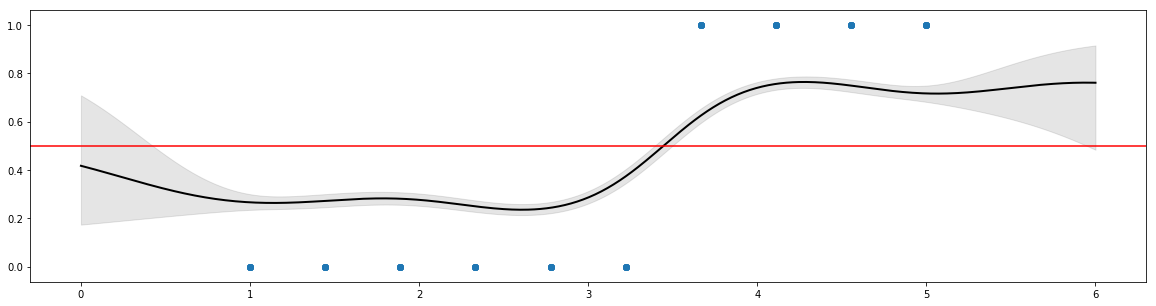

In [276]:
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

N = 10
sigma = .2
X_train = np.linspace(1,5,N).reshape(-1,1)
X_train = np.concatenate(5*[X_train])
X_train.sort(axis=0)
Y_train = np.concatenate([-1.0*np.ones(30),np.ones(X_train.shape[0]-30)])

n = 500
X_test = np.linspace(0,6,n).reshape(-1,1)

model = gaussian_process_classification_binomial()
model.train(X_train,Y_train)
mu_predictions, var_predictions = model.predict(X_test)


plt.figure(figsize=(20,5))
Y_train[Y_train == -1] = 0
plt.scatter(X_train, Y_train)
plt.plot(X_test, sigmoid(mu_predictions), 'k', mew=1, lw=2, label='Mean Prediction')
plt.fill_between(X_test[:,0], 
                 sigmoid(mu_predictions[:,0] - 1.96*np.sqrt(var_predictions)), 
                 sigmoid(mu_predictions[:,0] + 1.96*np.sqrt(var_predictions)),
                 color='k', alpha=.1, label='95% Credible Interval' )
plt.axhline(0.5,c='r')
plt.show()

### Gaussian Process Classification (Multinomial)

In [365]:
class guassian_process_classification_multinomial(object):
    def __init__(self):
        self.l = 0.5
        self.var_k = 1.0
        self.var_l = 0.2
        
    def preprocess(self,x,y=None):
        if len(x.shape) == 1:
            x = x.reshape(-1,1)
        if y is not None:
            y = y.reshape(-1,1)
        return x,y
    
    def rbf_kernel(self,a,b):
        z = np.sum(a**2,1).reshape(-1,1) + np.sum(b**2,1) - 2.0*a.dot(b.T)
        return self.var_k * np.exp(-0.5 * (1.0/self.l) * z)
    
    def sigmoid(self,z):
        return 1.0 / (1.0 + np.exp(-z))
    
    def softmax(self,predictions):
        return predictions / predictions.sum(axis=1).reshape(-1,1)
    
    def predict(self,x,y,x_s):
        x,y = self.preprocess(x,y)
        n_classes = np.unique(y).shape[0]
        
        predictions = []
        
        for i in range(n_classes):
            y_train = np.where(y==i,1,-1)
            K = self.rbf_kernel(x,x) + np.eye(x.shape[0])*self.var_l
            K = np.linalg.inv(K)
            K_s = self.rbf_kernel(x_s,x)
            mu = K_s.dot(K).dot(y_train)
            mu = self.sigmoid(mu)
            predictions.append(mu)
            
        predictions = np.array(predictions).T[0]
        predictions = self.softmax(predictions)
        
        return predictions

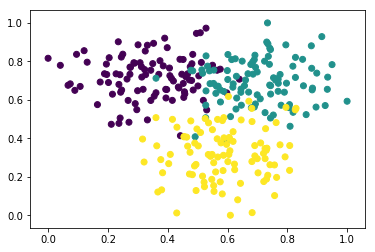

In [313]:
n = 100
cov = [[5,0],[0,5]]

x1 = np.random.multivariate_normal(mean=[2,10],cov=cov,size=n)
y1 = np.zeros(n)
x2 = np.random.multivariate_normal(mean=[8,10],cov=cov,size=n)
y2 = np.ones(n)
x3 = np.random.multivariate_normal(mean=[6,3],cov=cov,size=n)
y3 = np.ones(n)*2

x = np.concatenate([x1,x2,x3])
y = np.concatenate([y1,y2,y3]).reshape(-1,1)

X_std = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
x = X_std * (1.0 - 0.0) + 0.0

plt.scatter(x[:,0],x[:,1],c=y)
plt.show()

In [379]:
model = guassian_process_classification_multinomial()
predictions = model.predict(x,y,x).argmax(axis=1)

acc = 100.0 * y[y == predictions.reshape(-1,1)].shape[0] / y.shape[0]

print "Accuracy: {}%".format(acc)

Accuracy: 91.0%
